In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import astropy.units as u

from model_spec import model_spec
import polModel
from draine_dust_torus_model import ddust_torus
from gas_torus_model import gas_torus

## Spectrum, spectrum model and general pol model object

In [2]:
#Load the spectrum. 
spec, spec_model = model_spec()

In [3]:
#Load the general pol modeling objects. 
#import importlib
#importlib.reload(polModel_single_los)
pol_model = polModel.PolModel(spec, spec_model)

In [4]:
#Dictionaries to save the results.
xopt_all  = dict()
mod_p_all = dict() 

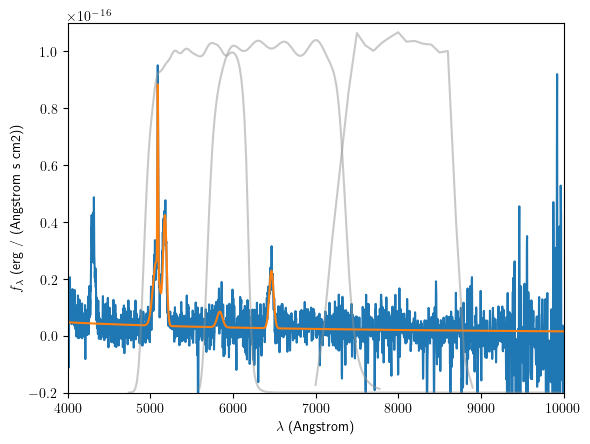

In [5]:
#Plot the spectrum, the best-fit model, and the filter curves.
pol_model.spec_plot()

In [6]:
#General plotting function
def pol_plot(mod_p, spec):

    data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    p_measured = data[:,0]
    p_unc = data[:,1]

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    for scat_type in mod_p.keys():
        if scat_type[-3:]=="LMC":
            fmt = '^'
        elif scat_type[-3:]=="SMC":
            fmt = 's'
        elif scat_type[-2:]=="MW":
            fmt = 'P'
        else:
            fmt='p'

        ax.plot(wave, mod_p[scat_type], fmt, label=scat_type)

    ax.legend(ncol=3)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Pure Gas Polarization

#### Same inclination for Continuum and Lines

In [7]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.gas_obj = gas_torus()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi = a_pars[1]
        return self.gas_obj.pfrac(([theta],[psi])).flatten()[0] * np.ones(len(lam))
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

In [8]:
scat_obj = Gas_Gas()

##### Force the same polarization angle. 

In [9]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([0., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG0"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[-1.82672666e-20  7.46991506e+01  7.46213413e+01]
19.136796922013193


##### Allow for different polarization angles.

In [10]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[6.98461467e-03 7.46045529e+01 7.46084560e+01]
19.136798154682417


#### Allow for independent torus opening angles for lines and continuum.

I *believe* that a scatterer very near the accretion disk should be able to be modeled by allowing for different opening angles, which in that model would just simply become for the lines the size of the BLR ring shining into a small scatterer, and for the continuum it would become the covering angle by the scatterer.

In [11]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.gas_obj = gas_torus()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi_A = a_pars[1]
        return self.gas_obj.pfrac(([theta],[psi_A])).flatten()[0] * np.ones(len(lam))
    
    #Emission line polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0]
        return self.gas_obj.pfrac(([theta],[psi_B])).flatten()[0] * np.ones(len(lam))
    

In [12]:
scat_obj = Gas_Gas()

In [13]:
x0 = np.array([0., 80., 50., 50.])
min_vals = np.array([0., 0., 0., 0.])
max_vals = np.array([90., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG2"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[44.77876522 62.18797259 72.73468127 50.42859191]
4.942818739124445e-13


## Pure dust polarization

In [14]:
dust_types = ["SMC", "LMC", "MW"]

#### Require the same polarization for the continuum and the emission lines.

In [15]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.dust_obj = ddust_torus(self.dust_type, fw=self.fw, bw=self.bw)

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta, psi)).flatten()
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

##### Force the same polarization angle. 

In [16]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([0., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD0_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[1.91674751e-22 6.52603640e+01 4.78868345e+01]
407.07940091432704
FW
`xtol` termination condition is satisfied.
[2.03528047e-25 5.92128607e+01 3.77646380e+01]
380.64679010502306
BW
`xtol` termination condition is satisfied.
[-4.15626371e-25  6.09999995e+01  6.10000000e+01]
391.9755894199099

LMC
FWBW
`xtol` termination condition is satisfied.
[1.26169008e-22 6.50632781e+01 4.79647134e+01]
618.229381218082
FW
`xtol` termination condition is satisfied.
[4.85509210e-25 5.30115478e+01 3.24226275e+01]
540.2959384518124
BW
`xtol` termination condition is satisfied.
[1.23781887e-23 7.09999994e+01 6.36080512e+01]
609.0586912103984

MW
FWBW
`gtol` termination condition is satisfied.
[4.98056667e-22 3.77492950e+01 4.20270774e-05]
267.2403369954578
FW
`xtol` termination condition is satisfied.
[-3.21845494e-26  4.08347182e+01  1.28658956e+01]
193.0472421295669
BW
`xtol` termination condition is satisfied.
[2.38949970e-28 9.00000000e+01 5.8349222

##### Allow for different polarization angles. 

In [17]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`gtol` termination condition is satisfied.
[75.40860449 84.80059403 30.90237506]
6.1865605025133775e-09
FW
`gtol` termination condition is satisfied.
[75.23919145 89.99998261 32.67595733]
0.010617730627644444
BW
`gtol` termination condition is satisfied.
[75.40096484 89.3944287  32.65436993]
5.5945618084949144e-11

LMC
FWBW
`xtol` termination condition is satisfied.
[8.56969620e+01 8.26543298e+01 2.62455974e-06]
30.266490097848482
FW
`xtol` termination condition is satisfied.
[8.43915096e+01 8.06474264e+01 1.84037413e-06]
12.289061171167841
BW
`xtol` termination condition is satisfied.
[83.95006441 89.99458095 15.99999996]
28.951760403612898

MW
FWBW
`gtol` termination condition is satisfied.
[75.41084007 89.99979349 25.19829563]
0.14954685542703205
FW
`gtol` termination condition is satisfied.
[74.29288924 86.85015792 25.79809297]
1.6057570894210648e-10
BW
`gtol` termination condition is satisfied.
[74.98534637 89.99999927 26.01104096]
0.04292935245448806



## Gas and Dust polarization 

##### Require the same inclination

In [22]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.dust_obj = ddust_torus(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = gas_torus()

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi_A = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta, psi_B)).flatten()
    

In [23]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 45.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 3.40572411 73.05294568 42.02000939 89.22297698]
159.58497380662848
FW
`xtol` termination condition is satisfied.
[ 3.45551142 60.90395752 25.8599536  79.62561455]
123.57580240524845
BW
`xtol` termination condition is satisfied.
[ 5.5785811  89.99772939 48.71427222 89.15312393]
163.79516761210033

LMC
FWBW
`xtol` termination condition is satisfied.
[ 5.56955365 72.61949075 41.36539784 89.1839526 ]
368.4312828354045
FW
`xtol` termination condition is satisfied.
[ 2.37332044 49.09147734  0.09998714 74.90611443]
222.66719099594343
BW
`xtol` termination condition is satisfied.
[ 4.74143359 89.98692939 48.56592042 89.18527961]
374.3721789928633

MW
FWBW
`xtol` termination condition is satisfied.
[5.88698487e+00 4.87266462e+01 1.60027360e-02 8.96235541e+01]
91.58102188515619
FW
`xtol` termination condition is satisfied.
[ 3.73921614 47.75131157  0.99942417 72.36409951]
20.6203839799825
BW
`xtol` termination condition is satisfied.
[ 4.4522

##### Allow for different inclinations

In [24]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 2

        #Load the simple gas model. 
        self.dust_obj = ddust_torus(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = gas_torus()

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta_A = a_pars[0] * np.ones(len(lam))
        psi_A   = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta_A, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        b_pars = x[self.npar_a+1:]
        theta_B = b_pars[0] * np.ones(len(lam))
        psi_B   = b_pars[1] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta_B, psi_B)).flatten()
    

In [25]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 80., 45.])
    min_vals = np.array([0., 0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG2_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 3.70570092 73.79564327 42.53946573 57.08738282 89.52165226]
159.53594878174846
FW
`xtol` termination condition is satisfied.
[ 4.9044661  60.83747217 25.74913607 56.36492015 78.4142185 ]
123.57375778799823
BW
`xtol` termination condition is satisfied.
[ 4.78331266 89.98239039 48.71879161 89.9882722  89.1564358 ]
163.8259976550474

LMC
FWBW
`xtol` termination condition is satisfied.
[ 3.16648742 72.65997855 41.39910202 52.92349534 89.61337588]
368.4141912085532
FW
`xtol` termination condition is satisfied.
[ 4.54850839 49.0777162   0.28001108 55.21190991 76.38086026]
222.71415062153127
BW
`xtol` termination condition is satisfied.
[ 5.63041813 89.99670038 48.57914069 88.00774002 89.96807989]
374.37578370363053

MW
FWBW
`xtol` termination condition is satisfied.
[7.76086512e+00 4.87283436e+01 7.16875048e-02 3.55214495e+01
 8.96946380e+01]
91.58828680593508
FW
`xtol` termination condition is satisfied.
[ 9.84051802 47.73968403  0.61015

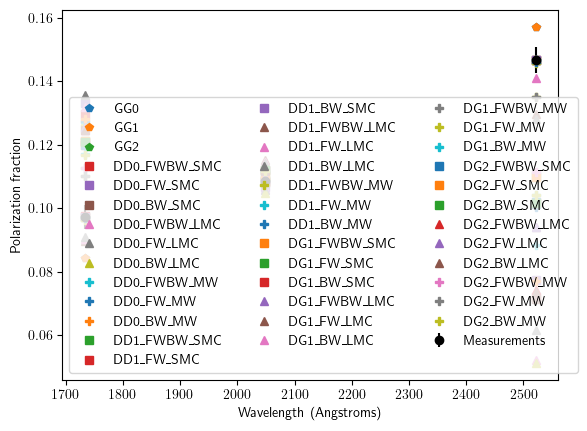

In [26]:
pol_plot(mod_p_all, spec)

In [27]:
#Rank solutions from best to worse. 
model_names = list(xopt_all.keys())
fun_all = np.zeros(len(model_names))
for i, mname in enumerate(model_names):
    fun_all[i] = xopt_all[mname].fun
k = np.argsort(fun_all)
for kk in k:
    mname = model_names[kk]
    print(mname, xopt_all[mname].fun, xopt_all[mname].x)

GG2 4.942818739124445e-13 [44.77876522 62.18797259 72.73468127 50.42859191]
DD1_BW_SMC 5.5945618084949144e-11 [75.40096484 89.3944287  32.65436993]
DD1_FW_MW 1.6057570894210648e-10 [74.29288924 86.85015792 25.79809297]
DD1_FWBW_SMC 6.1865605025133775e-09 [75.40860449 84.80059403 30.90237506]
DD1_FW_SMC 0.010617730627644444 [75.23919145 89.99998261 32.67595733]
DD1_BW_MW 0.04292935245448806 [74.98534637 89.99999927 26.01104096]
DD1_FWBW_MW 0.14954685542703205 [75.41084007 89.99979349 25.19829563]
DD1_FW_LMC 12.289061171167841 [8.43915096e+01 8.06474264e+01 1.84037413e-06]
GG0 19.136796922013193 [-1.82672666e-20  7.46991506e+01  7.46213413e+01]
GG1 19.136798154682417 [6.98461467e-03 7.46045529e+01 7.46084560e+01]
DG2_FW_MW 20.609811025947614 [ 9.84051802 47.73968403  0.61015629 45.43605854 71.59409051]
DG1_FW_MW 20.6203839799825 [ 3.73921614 47.75131157  0.99942417 72.36409951]
DD1_BW_LMC 28.951760403612898 [83.95006441 89.99458095 15.99999996]
DD1_FWBW_LMC 30.266490097848482 [8.56969620